In [1]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt 
import seaborn as sns
import dl_models
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.metrics import confusion_matrix

In [2]:
seed_value = 0
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

##### Load and drop "bike" and "stand" label from HHAR Dataset

In [3]:
data = np.load('/Users/Eshita/Downloads/Artifact-UniHAR/dataset/hhar/data_20_120.npy')
labels = np.load('/Users/Eshita/Downloads/Artifact-UniHAR/dataset/hhar/label_20_120.npy')
data.shape, labels.shape

((9166, 120, 6), (9166, 120, 3))

In [4]:
unique_labels = np.unique(labels[:,0,2])
print("Unique filtered labels:", unique_labels)

Unique filtered labels: [0. 1. 2. 3. 4. 5.]


In [5]:
bike_label = 0  # label for "bike"
stand_label = 4  # label for "stand"

mask = (labels[:, 0, 2] != bike_label) & (labels[:, 0, 2] != stand_label) # creating a mask for non-bike and non-stand entries

# Apply the mask to filter data and labels
filtered_data = data[mask]
filtered_labels = labels[mask]
filtered_data.shape, filtered_labels.shape

((6471, 120, 6), (6471, 120, 3))

In [6]:
# Save the filtered data and labels back if needed
np.save('dataset/hhar/filtered_data.npy', filtered_data)
np.save('dataset/hhar/filtered_labels.npy', filtered_labels)

##### Train the model on HHAR Dataset and save it

In [7]:
data = np.load('dataset/hhar/filtered_data.npy')
labels = np.load('dataset/hhar/filtered_labels.npy')
unique_labels = np.unique(filtered_labels[:,0,2])
print("Unique filtered labels:", unique_labels)

model_user_dict = {}

for sequence_index, label_sequence in enumerate(labels):
    user_index = int(label_sequence[0, 0])  # extracts user index
    device_index = int(label_sequence[0, 1])  # extracts device index
    gt_index = label_sequence[0, 2]  # extracs ground truth index

    if device_index not in model_user_dict:
        model_user_dict[device_index] = {}

    if user_index not in model_user_dict[device_index]:
        model_user_dict[device_index][user_index] = {'data': [], 'labels': []}

    # Append data and labels
    model_user_dict[device_index][user_index]['data'].append(data[sequence_index])
    model_user_dict[device_index][user_index]['labels'].append(gt_index)

for device in model_user_dict.keys():
    for user in model_user_dict[device].keys():
        model_user_dict[device][user]['data'] = np.array(model_user_dict[device][user]['data'])
        model_user_dict[device][user]['labels'] = np.array(model_user_dict[device][user]['labels'])

# To train model per device per user
def get_per_device_per_user_acc():
    acc_dict = {}
    for device_index in model_user_dict.keys():
        for user_index in model_user_dict[device_index].keys():
            data_ = model_user_dict[device_index][user_index]['data']
            labels_ = model_user_dict[device_index][user_index]['labels']
            labels_ = np.array(labels_)
            print("Device: ", device_index, "User: ", user_index, "Data: ", data_.shape, "Labels: ", labels_.shape)
            label_mapping = {1: 0, 2: 1, 3: 2, 5: 3}
            labels_ = np.array([label_mapping[label] for label in labels_])
            model = dl_models.dense_network(input_dim=data_.shape[1:], output_dim=4)  
            kfInner = StratifiedKFold(4, shuffle=True, random_state=seed_value)
            train_ind, val_ind = next(kfInner.split(data_, labels_))
            X_train, X_test = data_[train_ind], data_[val_ind]
            y_train, y_test = labels_[train_ind], labels_[val_ind]
            early_stopping = EarlyStopping(
                monitor='val_loss',  
                patience=5,         
                verbose=1,          
                mode='min',         
                restore_best_weights=True  
            )
            history = model.fit(X_train, y_train,
                                batch_size=128,
                                epochs=50,
                                verbose=0,
                                validation_data=(X_test, y_test),
                                shuffle=True,
                                callbacks=[early_stopping]
                                )

            acc_dict[(device_index, user_index)] = model.evaluate(X_test, y_test, verbose=0)[1]
            del model
    return acc_dict

# To train model per device across all users
def get_per_device_all_users():
    acc_dict = {}
    for device_index in model_user_dict.keys():
        data_ = []
        labels_ = []
        for user_index in model_user_dict[device_index].keys():
            data_.append(model_user_dict[device_index][user_index]['data'])
            labels_.append(model_user_dict[device_index][user_index]['labels'])
        data_ = np.concatenate(data_)
        labels_ = np.concatenate(labels_)
        print("Device: ", device_index, "Data: ", data_.shape, "Labels: ", labels_.shape)
        label_mapping = {1: 0, 2: 1, 3: 2, 5: 3}
        labels_ = np.array([label_mapping[label] for label in labels_])
        model = dl_models.dense_network(input_dim=data_.shape[1:], output_dim=4)
        kfInner = StratifiedKFold(4, shuffle=True, random_state=seed_value)
        train_ind, val_ind = next(kfInner.split(data_, labels_))
        X_train, X_test = data_[train_ind], data_[val_ind]
        y_train, y_test = labels_[train_ind], labels_[val_ind]
        early_stopping = EarlyStopping(
            monitor='val_loss',  
            patience=5,         
            verbose=1,          
            mode='min',         
            restore_best_weights=True  
        )
        history = model.fit(X_train, y_train,
                            batch_size=128,
                            epochs=50,
                            verbose=0,
                            validation_data=(X_test, y_test),
                            shuffle=True,
                            callbacks=[early_stopping]
                            )

        acc_dict[device_index] = model.evaluate(X_test, y_test, verbose=0)[1]
        del model
    return acc_dict

# To train model across all devices and users
def get_all_devices_all_users():
    acc_dict = {}
    data_ = []
    labels_ = []
    for device_index in model_user_dict.keys():
        for user_index in model_user_dict[device_index].keys():
            data_.append(model_user_dict[device_index][user_index]['data'])
            labels_.append(model_user_dict[device_index][user_index]['labels'])
    data_ = np.concatenate(data_)
    labels_ = np.concatenate(labels_)
    print("Data: ", data_.shape, "Labels: ", labels_.shape)

    label_mapping = {1: 0, 2: 1, 3: 2, 5: 3}
    labels_ = np.array([label_mapping[label] for label in labels_])

    # print unique labels
    unique_labels = np.unique(labels_)
    print("Unique labels:", unique_labels)

    model = dl_models.dense_network(input_dim=data_.shape[1:], output_dim=4)
    
    kfInner = StratifiedKFold(10, shuffle=True, random_state=seed_value)
    train_ind, val_ind = next(kfInner.split(data_, labels_))
    _, data_ = data_[train_ind], data_[val_ind]
    _, labels_ = labels_[train_ind], labels_[val_ind]
    print("Data: ", data_.shape, "Labels: ", labels_.shape)

    # Train and validation split
    kfInner = StratifiedKFold(4, shuffle=True, random_state=seed_value)
    train_ind, val_ind = next(kfInner.split(data_, labels_))
    X_train, X_test = data_[train_ind], data_[val_ind]
    y_train, y_test = labels_[train_ind], labels_[val_ind]
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        mode='min',
        restore_best_weights=True
    )
    history = model.fit(X_train, y_train,
                        batch_size=128,
                        epochs=50,
                        verbose=0,
                        validation_data=(X_test, y_test),
                        shuffle=True,
                        callbacks=[early_stopping]
                        )
    print("Model trained")
    
    model.save('hhar_all_devices_all_users_model.h5')
    print("Model trained and saved successfully!")
    
    acc_dict = model.evaluate(X_test, y_test, verbose=0)[1]
    del model
    return acc_dict

# acc_dict = get_per_device_all_users()
# print("Mean Accuracy per device: ", np.mean(list(acc_dict.values())))

# acc_dict = get_per_device_per_user_acc()
# print("Mean Accuracy per user per device: ", np.mean(list(acc_dict.values())))

acc_dict = get_all_devices_all_users()
print("Accuracy for all devices and all users: ", acc_dict)
#print(model_user_dict)

Unique filtered labels: [1. 2. 3. 5.]
Data:  (6471, 120, 6) Labels:  (6471,)
Unique labels: [0 1 2 3]
Data:  (648, 120, 6) Labels:  (648,)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 46: early stopping
Restoring model weights from the end of the best epoch: 41.


Model trained
Model trained and saved successfully!
Accuracy for all devices and all users:  0.7160493731498718


##### Load UCI Dataset, drop "standing" and "lying" label and change mapping

In [8]:
data = np.load('/Users/Eshita/Downloads/Artifact-UniHAR/dataset/uci/data_20_120.npy')
labels = np.load('/Users/Eshita/Downloads/Artifact-UniHAR/dataset/uci/label_20_120.npy')
data.shape, labels.shape

((2088, 120, 6), (2088, 120, 2))

In [9]:
lying_label = 5  # label for "lying"
standing_label = 4 # label for "standing"
mask = (labels[:, 0, 0] != lying_label ) & (labels[:, 0, 0] != standing_label) # Create a mask for non-lying and non-standing entries

# Apply the mask to filter data and labels
filtered_data = data[mask]
filtered_labels = labels[mask]
filtered_data.shape, filtered_labels.shape

((1289, 120, 6), (1289, 120, 2))

In [10]:
np.save('dataset/uci/filtered_data.npy', filtered_data)
np.save('dataset/uci/filtered_labels.npy', filtered_labels)

In [11]:
# Load filtered data and labels
filtered_data = np.load('dataset/uci/filtered_data.npy')
filtered_labels_uci = np.load('dataset/uci/filtered_labels.npy')
np.unique(filtered_labels[:, 0, 0])

array([0., 1., 2., 3.])

In [12]:
filtered_data = np.load('dataset/uci/filtered_data.npy')
filtered_labels_uci = np.load('dataset/uci/filtered_labels.npy')

# Mapping UCI to HHAR
mapping = {
    0: 3,  # walking (UCI) -> walk (HHAR)
    1: 2,  # upstairs -> upstairs
    2: 1,  # downstairs -> downstairs
    3: 0,  # sitting -> sit
}

mapped_labels = np.array([mapping[label] for label in filtered_labels_uci[:, 0, 0]])

print(f"Mapped labels shape: {mapped_labels.shape}")
print(f"Unique mapped labels: {np.unique(mapped_labels)}")

# Ensure that the number of mapped_labels matches the filtered_data
if mapped_labels.shape[0] != filtered_data.shape[0]:
    print("Warning: Mismatch between filtered_data and mapped_labels counts!")
else:
    print("Counts match, proceeding to model evaluation.")


Mapped labels shape: (1289,)
Unique mapped labels: [0 1 2 3]
Counts match, proceeding to model evaluation.


##### Load the saved HHAR model and test on UCI dataset

In [13]:
# Load and evaluate the model
model = load_model('hhar_all_devices_all_users_model.h5')

loss, accuracy = model.evaluate(filtered_data, mapped_labels, verbose=1)
print(f"Model Loss: {loss}, Model Accuracy: {accuracy * 100:.2f}%")

predictions = model.predict(filtered_data)
predicted_classes = np.argmax(predictions, axis=1)

print("Predicted classes:", predicted_classes)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2656 - loss: 5.9514
Model Loss: 6.1356306076049805, Model Accuracy: 28.63%
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Predicted classes: [0 0 0 ... 0 0 0]


Confusion Matrix:
 [[358   0   4   0]
 [254   0   0   0]
 [305   0  11   2]
 [355   0   0   0]]


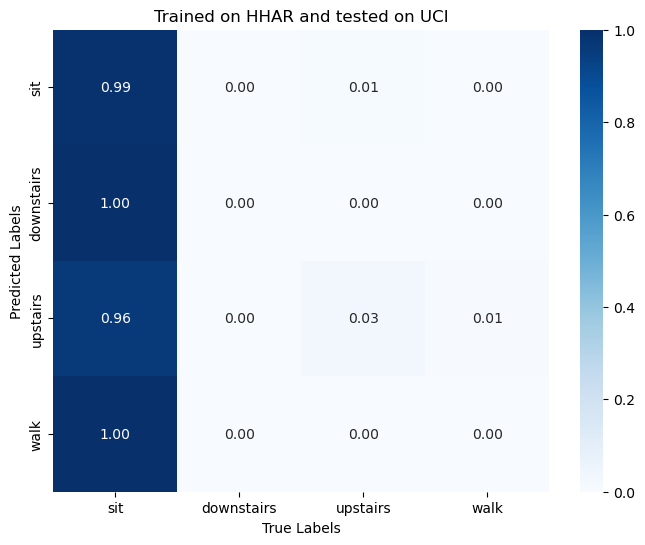

In [14]:
# Confusion matrix
conf_matrix = confusion_matrix(mapped_labels, predicted_classes)
print("Confusion Matrix:\n", conf_matrix)

# Normalized confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

class_names = ['sit', 'downstairs', 'upstairs', 'walk']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('Trained on HHAR and tested on UCI')
plt.show()